# Introduction 

This is a copy of the  example given on the Deeptime documentation website [here](https://deeptime-ml.github.io/latest/notebooks/examples/ala2-example.html).  Run this example first before trying any of the experimental code to make sure everting is working as it should! 

In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import mdshare  

from deeptime.util.types import to_dataset
from tqdm.notebook import tqdm  # progress bar
from deeptime.decomposition.deep import VAMPNet
from torch.utils.data import DataLoader


In [39]:
device = torch.device("cpu")

In [2]:
assert torch.cuda.is_available(), "Need a GPU with CUDA" 
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True

AssertionError: Need a GPU with CUDA

## Globals

In [17]:
data_dir = "/home/matthewb/online_vampnets/data"
data_dir = "/home/matthewb/ANI-Peptides/outputs/production_aaa_capped_amber_equilibrated_amber_112650_010322/trajectory_split_092420_080322"
lag_time = 1


In [32]:

# ala_coords_file = mdshare.fetch(
#     "alanine-dipeptide-3x250ns-heavy-atom-positions.npz", working_directory=data_dir
# )

# dihedral_file = mdshare.fetch(
#     "alanine-dipeptide-3x250ns-backbone-dihedrals.npz", working_directory=data_dir
# )

file_coords = os.path.join(data_dir, "coords_archive.npz")
with np.load(file_coords) as fh:
    data_coords = fh["arr_0"].astype(np.float32)

file_dihedral = os.path.join(data_dir, "dihedrals_archive.npz")
with np.load(file_dihedral) as fh:
    data_dihedral = fh["arr_0"].astype(np.float32)
    # data_dihedral = np.reshape(data_dihedral, (-1, 2))
    # print(data_dihedral.shape)


In [24]:
# print(data_dihedral.shape)

(129222, 2, 3)


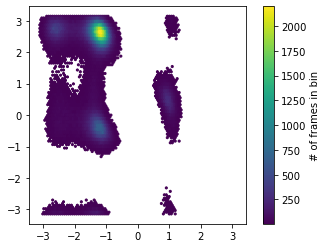

In [33]:
f, ax = plt.subplots(1, 1)

# hb = ax.hexbin(*np.concatenate(data_dihedral).T, mincnt=5)
x = data_dihedral[:, 0, :].flat
y = data_dihedral[:, 1, :].flat
hb = ax.hexbin(x,y, mincnt=5)
# hb = ax.hexbin(data_dihedral[:, 0], data_dihedral[:, 1], mincnt=5)
ax.set_aspect('equal')
cb = f.colorbar(hb, ax=ax)
cb.set_label('# of frames in bin')

The following function splits up each trajectory in data into pairs (X_t, X_t+lagtime) and then puts all pairs from each trajectory into a single generator. 

So for lagtime = 1: 
 - There are three trajectories. 
 - Each trajectory is 250000 x 30 (30 being the number of coordinates)
 - So there are 249999 time lagged pairs for each trajectory. 
 - in total then there are 749997 time-lagged pairs. 
 - The dataset will have length 749997, each item will be a tuple of length 2 (Xt, Xt+1), and each tuple item will have length 30

In this case:
 - there is one trajectory
 - 

In [41]:
print(data_coords.shape)
dataset = to_dataset(data=data_coords, lagtime=1)
print(len(dataset), len(dataset[0]), len(dataset[0][0]))

(1129222, 42, 3)
46298102 2 3


In [36]:
n_coords = data_coords.shape[1]
n_val = int(len(dataset)*.3)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])


In [42]:
lobe = nn.Sequential(
    nn.BatchNorm1d(data_coords[0].shape[1]),
    nn.Linear(data_coords[0].shape[1], n_coords), nn.ELU(),
    nn.Linear(n_coords, 100), nn.ELU(),
    nn.Linear(100, 100), nn.ELU(),
    nn.Linear(100, 100), nn.ELU(),
    nn.Linear(100, 100), nn.ELU(),
    nn.Linear(100, 100), nn.ELU(),
    nn.Linear(100, 100), nn.ELU(),
    nn.Linear(100, n_coords), nn.ELU(),
    nn.Linear(n_coords, 6),
    nn.Softmax(dim=1)  # obtain fuzzy probability distribution over output states
)

lobe_timelagged = deepcopy(lobe).to(device=device)
lobe = lobe.to(device=device)
print(lobe)

Sequential(
  (0): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=3, out_features=42, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=42, out_features=100, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ELU(alpha=1.0)
  (7): Linear(in_features=100, out_features=100, bias=True)
  (8): ELU(alpha=1.0)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ELU(alpha=1.0)
  (11): Linear(in_features=100, out_features=100, bias=True)
  (12): ELU(alpha=1.0)
  (13): Linear(in_features=100, out_features=100, bias=True)
  (14): ELU(alpha=1.0)
  (15): Linear(in_features=100, out_features=42, bias=True)
  (16): ELU(alpha=1.0)
  (17): Linear(in_features=42, out_features=6, bias=True)
  (18): Softmax(dim=1)
)


In [43]:
vampnet = VAMPNet(lobe=lobe, lobe_timelagged=lobe_timelagged, learning_rate=5e-4, device=device)

In [44]:
loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [45]:
model = vampnet.fit(loader_train, n_epochs=30,
                    validation_loader=loader_val).fetch_model()

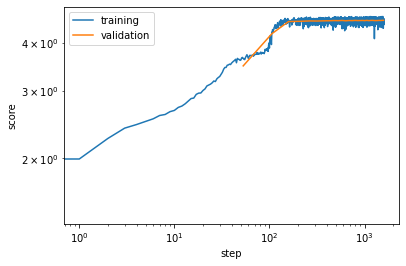

In [ ]:
plt.loglog(*vampnet.train_scores.T, label='training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend();



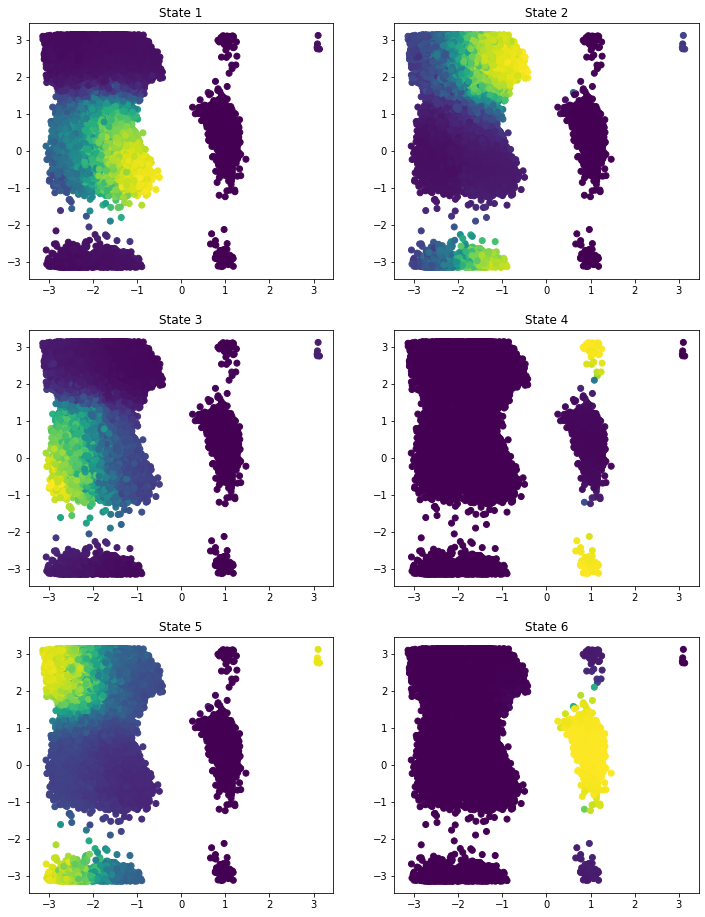

In [ ]:
state_probabilities = model.transform(data[0])

f, axes = plt.subplots(3, 2, figsize=(12, 16))
for i, ax in enumerate(axes.flatten()):
    ax.scatter(*dihedral[0][::5].T, c=state_probabilities[..., i][::5])
    ax.set_title(f'State {i+1}')



In [ ]:
state_probabilities = model.transform(data[0])
for ix, (mini, maxi) in enumerate(zip(np.min(state_probabilities, axis=0),
                                      np.max(state_probabilities, axis=0))):
    print(f"State {ix+1}: [{mini}, {maxi}]")

State 1: [6.91943132551387e-05, 0.7571644186973572]
State 2: [4.2454757931409404e-05, 0.7707315683364868]
State 3: [0.00038714290712960064, 0.6576177477836609]
State 4: [8.980524580692872e-05, 0.9358066320419312]
State 5: [4.7261455620173365e-05, 0.8100879192352295]
State 6: [4.5071465137880296e-05, 0.9833868145942688]


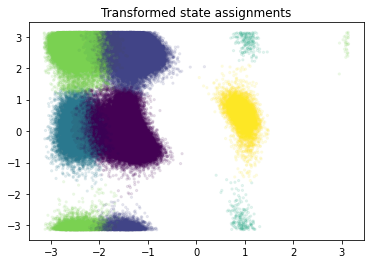

In [ ]:
assignments = state_probabilities.argmax(1)
plt.scatter(*dihedral[0].T, c=assignments, s=5, alpha=.1)
plt.title('Transformed state assignments');



In [ ]:
from deeptime.decomposition import VAMP

vamp_estimator = VAMP(lagtime=10, observable_transform=model)
vamp = vamp_estimator.fit(data).fetch_model()
print(f"VAMP-2 score under lag 10: s = {vamp.score(2).round(2)}")



VAMP-2 score under lag 10: s = 3.28


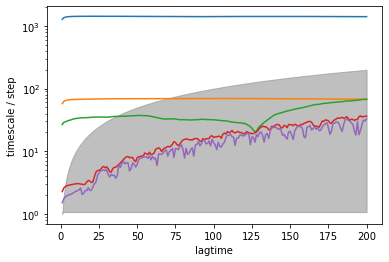

In [ ]:
lagtimes = np.arange(1, 201, dtype=np.int32)
timescales = []
for lag in lagtimes:
    ts = VAMP(lagtime=lag, observable_transform=model).fit(data).fetch_model().timescales(k=5)
    timescales.append(ts)

f, ax = plt.subplots(1, 1)
ax.semilogy(lagtimes, timescales)
ax.set_xlabel('lagtime')
ax.set_ylabel('timescale / step')
ax.fill_between(lagtimes, ax.get_ylim()[0]*np.ones(len(lagtimes)), lagtimes, alpha=0.5, color='grey')

In [ ]:
vamp_estimator = VAMP(lagtime=1, observable_transform=model)
vamp = vamp_estimator.fit(data).fetch_model()

validator = vamp_estimator.chapman_kolmogorov_validator(mlags=20)
cktest = validator.fit(data, n_jobs=1).fetch_model()

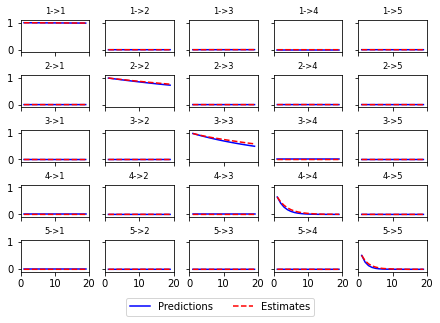

In [ ]:
n_states = len(vamp.singular_values)

tau = cktest.lagtimes[1]
steps = len(cktest.lagtimes)
fig, ax = plt.subplots(n_states, n_states, sharex=True, sharey=True, constrained_layout=True)
for i in range(n_states):
    for j in range(n_states):
        pred = ax[i][j].plot(cktest.lagtimes, cktest.predictions[:, i, j], color='b')
        est = ax[i][j].plot(cktest.lagtimes, cktest.estimates[:, i, j], color='r', linestyle='--')
        ax[i][j].set_title(str(i+1)+ '->' +str(j+1),
                                       fontsize='small')
ax[0][0].set_ylim((-0.1,1.1));
ax[0][0].set_xlim((0, steps*tau));
ax[0][0].axes.get_xaxis().set_ticks(np.round(np.linspace(0, steps*tau, 3)));
fig.legend([pred[0], est[0]], ["Predictions", "Estimates"], 'lower center', ncol=2,
           bbox_to_anchor=(0.5, -0.1));